In [123]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import figurefirst as fifi
import figure_functions as ff
from pybounds import SlidingEmpiricalObservabilityMatrix, SlidingFisherObservability, colorline
from drone_model_body_level import DroneSimulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set trajectory

In [124]:
dt = 0.1  # sampling time [s]
fs = 1 / dt  # sampling frequency [hz]
T = 4.0  # total time [s]
tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]

In [125]:
# Set the ambient wind
w = 0.5 * np.ones_like(tsim)
zeta = np.pi * np.ones_like(tsim)

In [126]:
# # Set the trajectory
# z =  0.5 * np.ones_like(tsim)  # elevation
# v_x =  0.8 * np.ones_like(tsim) + 0.01 * tsim  # forward velocity in body-level frame
# v_y =  0.001 * np.ones_like(tsim) + 0.01 * tsim  # sideways velocity in body-level frame
# psi = (np.pi/4) * np.ones_like(tsim)  # yaw heading
# 
# # Add turn(s)
# turn_times = [1.2, 3.0]
# turn_mags = [-np.pi/2, np.pi/2]
# for t, m in zip(turn_times, turn_mags):
#     index = int(t * fs)
#     psi[index:] = psi[index] + m
#     
# # Add accelerations(s)
# accel_times = [2.2, 4.0]
# accel_mags = [0.5, -1.0]
# for t, m in zip(accel_times, accel_mags):
#     index = int(t * fs)
#     v_x[index:] = v_x[index] + m

In [127]:
# Set nominal trajectory
z =  0.5 * np.ones_like(tsim)  # elevation
v_x =  0.8 * np.ones_like(tsim) + 0.0 * tsim  # forward velocity in body-level frame
v_y =  0.0 * np.ones_like(tsim) + 0.0 * tsim  # sideways velocity in body-level frame
psi = (np.pi/4) * np.ones_like(tsim)  # yaw heading

# Add turn(s)
turn_times = [1.9]
turn_mags = [-np.pi/2]
for t, m in zip(turn_times, turn_mags):
    index = int(t * fs)
    psi[index:] = psi[index] + m
    
# Add accelerations(s)
accel_times = [1.9]
accel_mags = [0.0]
for t, m in zip(accel_times, accel_mags):
    index = int(t * fs)
    v_x[index:] = v_x[index] + m

# Run simulator

In [128]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=10, r_u=1e-2, control_mode='velocity_body_level')

In [129]:
# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)

In [130]:
# Run simulation
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 4.2878639698028564


# Plot trajectory in 2D

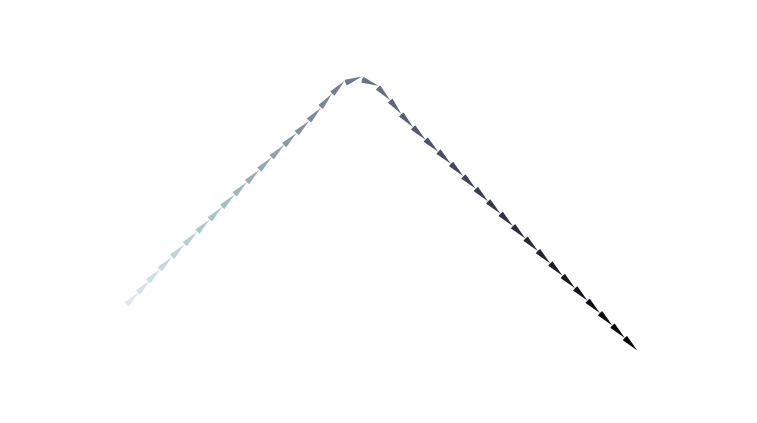

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

ff.plot_trajectory(x_sim['x'], x_sim['y'], x_sim['psi'],
                   color=t_sim,
                   ax=ax,
                   size_radius=0.08,
                   nskip=0)

fifi.mpl_functions.adjust_spines(ax, [])

In [132]:
# simulator.plot(name='setpoint')

# Observability

In [133]:
# Set time-window
time_window = 8

In [134]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=time_window, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 14.801278114318848


In [135]:
# Get O's
O_sliding = SEOM.get_observability_matrix()
n_window = len(O_sliding)
print(n_window, 'windows')

34 windows


In [136]:
o_sensors = ['psi', 'beta', 'gamma']
# o_sensors = ['psi', 'phi', 'theta', 'alpha', 'gamma']
# o_sensors = ['psi', 'phi', 'theta', 'alpha', 'gamma']
# o_sensors = ['psi', 'beta', 'gamma']
# o_sensors = ['psi', 'alpha', 'gamma', 'q', 'r']

o_states = None
# o_states = simulator.state_names[0:-5] + ['m', 'C', 'I_x']

window_size = 5
o_time_steps = np.arange(0, window_size, step=1)

In [137]:
o_states

In [138]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=0.1,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=window_size)

EV_aligned = SFO.get_minimum_error_variance()
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

In [139]:
EV_no_nan

,time,time_initial,x,y,z,v_x,v_y,v_z,phi,theta,...,omega_x,omega_y,omega_z,w,zeta,m,I_x,I_y,I_z,C
0,0.0,0.0,1000000.000000,1000000.000000,1000000.0,742051.622655,0.063999,999999.999999,3.453273,66.071732,...,658.151319,6997.643464,13.982622,374548.922055,211190.537943,30446.146862,4014.751214,4693.045126,10.846577,38523.154941
1,0.1,0.0,1000000.000000,1000000.000000,1000000.0,742051.622655,0.063999,999999.999999,3.453273,66.071732,...,658.151319,6997.643464,13.982622,374548.922055,211190.537943,30446.146862,4014.751214,4693.045126,10.846577,38523.154941
2,0.2,0.0,1000000.000000,1000000.000000,1000000.0,742051.622655,0.063999,999999.999999,3.453273,66.071732,...,658.151319,6997.643464,13.982622,374548.922055,211190.537943,30446.146862,4014.751214,4693.045126,10.846577,38523.154941
3,0.3,0.1,1000000.000000,1000000.000000,1000000.0,722868.690029,1444.467341,999999.999963,179.487796,2203.653928,...,62625.430249,870737.506609,51.970369,497012.929498,420445.409632,14546.803220,669.116476,790.748967,7.788873,18166.199709
4,0.4,0.2,999999.999949,999999.999954,1000000.0,777352.226807,465.253966,999999.999272,4449.281375,51801.632971,...,76291.289210,820364.483105,28.971969,540767.936744,569912.591165,21933.136176,1846.257174,2077.774391,55.480251,27621.515639
5,0.5,0.3,999999.999994,999999.999995,1000000.0,807808.057863,4.858501,999999.999960,37279.502523,389710.109950,...,76.647082,188520.679653,262.102599,539353.232462,582502.562392,81402.567693,13205.745193,15563.712409,168.366799,101415.687062
6,0.6,0.4,999999.999948,999999.999954,1000000.0,809715.701828,0.913076,999999.999975,11328.679653,118098.629157,...,52370.345873,767096.148842,70.838145,529968.464401,561568.925409,51880.049874,4851.809188,5333.793337,86.998828,50491.268695
7,0.7,0.5,999999.999925,999999.999929,1000000.0,819045.725480,4.074225,999999.999508,14648.340240,148667.193793,...,85331.588393,626059.795382,33.342913,552047.537924,602110.931291,98132.677603,12309.150463,12067.556833,521.355785,86364.907915
8,0.8,0.6,999999.999844,999999.999852,1000000.0,824591.460306,2.322667,999999.999231,38184.664853,413558.635275,...,14287.079830,10839.429812,25.408924,550563.169528,599134.126747,279165.554286,44614.442148,48121.646666,576.760213,279385.611935
9,0.9,0.7,999999.999990,999999.999990,1000000.0,818479.229172,0.072925,999999.999931,30792.956776,343320.722090,...,18189.100088,269479.342780,33.667469,556479.389035,606485.240516,265265.359254,30764.873135,31394.585354,1232.493999,215559.237518


# Plot state observability

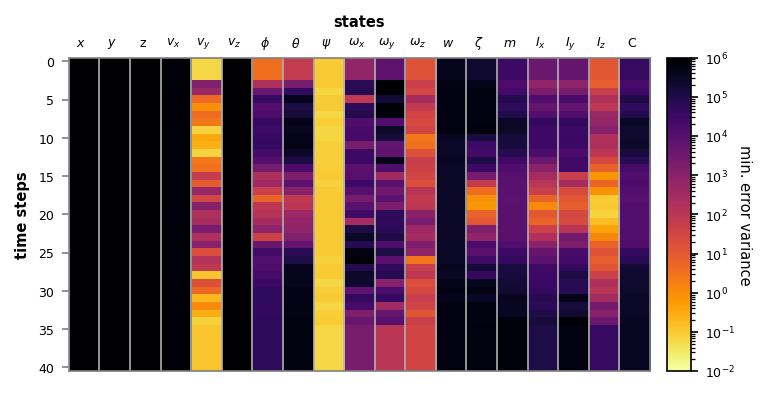

In [140]:
if o_states is None:
    state_labels = simulator.state_names
else:
    state_labels = o_states

cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(EV_no_nan.iloc[:, 2:].values, log_ticks=(-2, 6),
                                                        data_labels=state_labels, y_label='min. error variance')

In [ ]:
EV_no_nan

# Plot state observability on trajectory

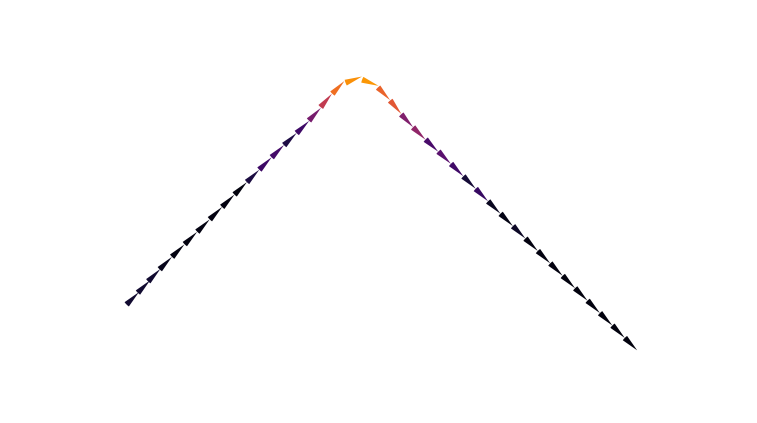

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

color = EV_no_nan['zeta'].values

ff.plot_trajectory(x_sim['x'], x_sim['y'], x_sim['psi'],
                   color=color,
                   ax=ax,
                   size_radius=0.08,
                   nskip=0,
                   colormap=cmap,
                   colornorm=cnorm)


fifi.mpl_functions.adjust_spines(ax, [])